In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.optimize import curve_fit
import numpy as np
import matplotlib 
import optuna
import pickle as pkl  
np.set_printoptions(suppress=True)
plt.rc('text', usetex=True)

dataDir = "/home/polivares/Dropbox/DocUSM/Researches/InfluenzaMeningococcal/Data/"
imageDir = "/home/polivares/Dropbox/DocUSM/Researches/InfluenzaMeningococcal/Scripts/images/"

In [2]:
# Load data
menSeries = pd.read_pickle(dataDir + "pkls/menSeries.pkl")
ausPop = pd.read_pickle(dataDir + "pkls/ausPop.pkl")

In [3]:
import os
if os.path.isfile(dataDir + "pkls/menSIRParams.pkl"):
    menParams = pkl.load(open(dataDir + "pkls/menSIRParams.pkl", "rb"))
else:
    menParams = {}

In [4]:
# Evaluation time
from datetime import datetime # Library for datetime format
from dateutil import relativedelta # Library to calculate delta time from date

year = 2017
startdate = str(year) + '-01'
enddate = str(year) + '-12'

#year = 2017
#startdate = '2017-04'
#enddate = '2017-12'


date_format = "%Y-%m"
sd = datetime.strptime(startdate, date_format)
ed = datetime.strptime(enddate, date_format)

n_months = relativedelta.relativedelta(ed, sd) # Number of months (delta time)
print(n_months)

relativedelta(months=+11)


In [5]:
# Timestamp parameters
t_start = 0.0; t_end = n_months.months; t_inc = 1
t_range = np.arange(t_start, t_end+t_inc, t_inc)

# Initial conditions
S0 = (ausPop[year] - menSeries[startdate])
I0 = (menSeries[startdate])
R0 = 0

SIR0 = [S0,I0,R0]

In [7]:
# Defining SIR isolated equations
def SIR_eqs(SIR0,t, beta, gamma):
    S0=SIR0[0]
    I0=SIR0[1]
    R0=SIR0[2]

    S = - beta * S0 * I0/ausPop[year]
    I = (beta * S0 * I0/ausPop[year]) - gamma * I0
    R = gamma * I0

    return (S,I,R)

# Fitting function from infected data and I state on SIR model
def fitSIR(t, beta, gamma):
    return spi.odeint(SIR_eqs,SIR0,t_range,args=(beta,gamma))[:,1] 

def fitErrorSIR(trial):
     #(9.00165750105233, 69.35210027387456, 8.35506567120736, 69.35957442372714, 10.060360325775953, 97.56183004648915, 4.957084610524714, 53.932494914485716)
    #beta1 = trial.suggest_float("beta1",8,10,step=0.0001)
    beta = trial.suggest_float("beta",1,100,step=0.0001)
    gamma = trial.suggest_float("gamma",1,150,step=0.0001)
    #w = trial.suggest_float("w",1,100)
    SIR_Res=fitSIR(t_range, beta, gamma)
    
    #c.Score Difference between model and data points
    def normMSE(data,model):
        n = len(data)
        mse = ((data-model)**2).sum()
        nmse = mse/(n*(data.sum()/n)*(model.sum()/n))
        
        return nmse

    return normMSE(menSeries[startdate:enddate],SIR_Res)

In [10]:
study = optuna.create_study()
study.optimize(fitErrorSIR, n_trials=5000)

study.best_params  # E.g. {'x': 2.002108042}

402492328.
[I 2021-03-30 03:39:44,094] Trial 4902 finished with value: 2220.7033202060097 and parameters: {'beta': 35.6287, 'gamma': 31.594}. Best is trial 4866 with value: 0.15395254402492328.
[I 2021-03-30 03:39:44,230] Trial 4903 finished with value: 1053.370130397848 and parameters: {'beta': 37.6563, 'gamma': 35.269200000000005}. Best is trial 4866 with value: 0.15395254402492328.
[I 2021-03-30 03:39:44,340] Trial 4904 finished with value: 15.22844604692304 and parameters: {'beta': 28.835700000000003, 'gamma': 39.097100000000005}. Best is trial 4866 with value: 0.15395254402492328.
[I 2021-03-30 03:39:44,448] Trial 4905 finished with value: 3.187606410548392 and parameters: {'beta': 31.732000000000003, 'gamma': 32.0324}. Best is trial 4866 with value: 0.15395254402492328.
[I 2021-03-30 03:39:44,644] Trial 4906 finished with value: 0.19128478674402427 and parameters: {'beta': 34.617200000000004, 'gamma': 34.598800000000004}. Best is trial 4866 with value: 0.15395254402492328.
[I 202

{'beta': 35.025600000000004, 'gamma': 34.979800000000004}

In [11]:
menParams[year] = [beta, gamma, bestscore]
pkl.dump(menParams, open(dataDir + 'pkls/menSIRParams.pkl','wb'))

NameError: name 'beta' is not defined

In [12]:
beta, gamma= study.best_params.values()
print(beta,gamma)

35.025600000000004 34.979800000000004


In [ ]:
#from scipy.optimize import fmin

#answ=fmin(score,(50, 50),full_output=1,maxiter=10000)
#bestParams=answ[0]
#bestscore=answ[1]
#beta,gamma=answ[0]
#paramsOpt=(beta,gamma)

#print(paramsOpt,bestscore)

# Evaluation

In [13]:
# Timestamp parameters
t_start = 0.0; t_end = n_months.months+12; t_inc = 0.01
t_eval = np.arange(t_start, t_end+t_inc, t_inc)

# Initial conditions
S0 = (ausPop[year] - menSeries[startdate])
I0 = (menSeries[startdate])
R0 = 0

SIR0 = [S0,I0,R0]

In [14]:
def menSIRSim(beta,gamma):    
    return spi.odeint(SIR_eqs,SIR0,t_eval,args=(beta,gamma))

In [15]:
SIR = menSIRSim(beta,gamma)
S = SIR[:,0]
I = SIR[:,1]
R = SIR[:,2]

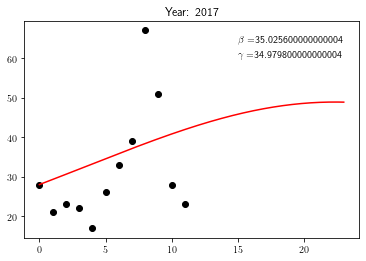

In [16]:
%matplotlib inline

plt.plot(t_range[:n_months.months+1], menSeries[startdate:enddate].values,'ok',label="Original data")
plt.plot(t_eval,I,'-r',label="Infected fit")
plt.text(15, 60, r'$\gamma = $' + str(gamma))
plt.text(15, 64, r'$\beta = $' + str(beta))
plt.title("Year: " + str(year))
plt.savefig(imageDir + "menIsolated/men_" + str(year) + ".png" )
plt.show()